<a href="https://colab.research.google.com/github/thefr33radical/hybrid_forecasting/blob/master/code/ARIMA_ANN_lynx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip uninstall pyramid
#!pip uninstall pyramid-arima
#!pip install statsmodels
#!pip install pyramid-arima

Saving lynx.csv to lynx (5).csv


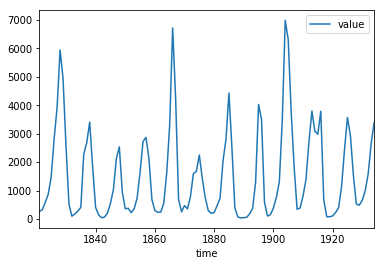

In [69]:
import pandas as pd 
import numpy as np
from google.colab import files
import io
from sklearn.metrics import r2_score,mean_squared_error as ms
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from pyramid.arima import auto_arima 

data = files.upload()
data = pd.read_csv(io.BytesIO(data["lynx.csv"]))
data = data.set_index("time")

data.plot()
plt.show()

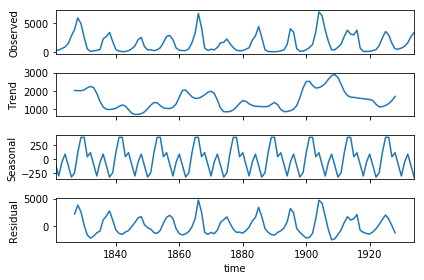

In [83]:
ndata= seasonal_decompose(data,model="additive",freq=12)
ndata.plot()
plt.show()

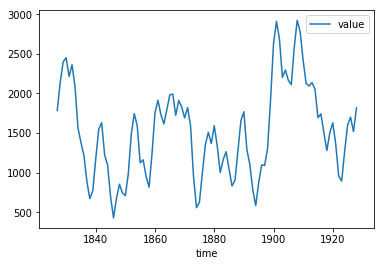

In [84]:
linear_data = ndata.trend+ ndata.seasonal 
linear_data.plot()
plt.show()

In [74]:
# Indvidual ARIMA

ldata=data.copy(deep=True)
#ldata["value"] = ldata["value"]-ldata["value"].shift(1)

stepwise_model1 = auto_arima(ldata,start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, 
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model1.aic())

"""
# 14 period horizon
train = data.loc['1821-01-01':'1920-01-01']
test = data.loc['1921-01-01':'1934-01-01']

"""

# 14 period horizon
train = data.loc['1821-01-01':'1920-01-01']
test = data.loc['1920-01-01':'1934-01-01']

print(len(test))
stepwise_model1.fit(train)

future_forecast1 = stepwise_model1.predict(n_periods=14)

1725.5499408665708
14


In [75]:
# Individual ARIMA Score
print(ms(test,future_forecast1))

5279111.4998457795


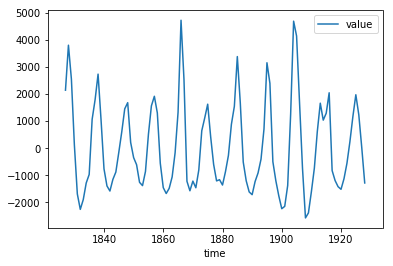

            value
time             
1821          NaN
1822          NaN
1823          NaN
1824          NaN
1825          NaN
1826          NaN
1827  2143.886188
1828  3807.089892
1829  2552.451003
1830   126.895448
1831 -1691.525849
1832 -2263.308256
1833 -1903.334877
1834 -1287.683835
1835  -972.845293
1836  1066.560957
1837  1793.415123
1838  2737.482832
1839  1054.594522
1840  -763.993441
1841 -1395.798997
1842 -1584.896219
1843 -1155.442515
1844  -883.308256
1845  -152.209877
1846   605.149498
1847  1454.404707
1848  1682.060957
1849   211.456790
1850  -348.725502
...           ...
1905  4147.456790
1906  1682.482832
1907  -744.886960
1908 -2579.022377
1909 -2393.959877
1910 -1608.683835
1911  -738.363812
1912   619.214892
1913  1663.367670
1914  1036.437114
1915  1291.599151
1916  2048.150077
1917  -829.334877
1918 -1197.558835
1919 -1423.136960
1920 -1521.272377
1921 -1131.043210
1922  -558.933835
1923   239.802855
1924  1166.381559
1925  1975.117670
1926  1235.062114
1927    19

In [114]:
non_linear_data = ndata.resid 
non_linear_data.plot()
plt.show()

print(non_linear_data)

In [89]:
# Hybrid ARIMA


stepwise_model2 = auto_arima(non_linear_data[6:-6],start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, 
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model2.aic())

"""
# 14 period horizon
train = data.loc['182-01-01':'1920-01-01']
test = data.loc['1921-01-01':'1934-01-01']

"""

# 14 period horizon
train2 = non_linear_data.loc['1827-01-01':'1918-01-01']
test2 = non_linear_data.loc['1918-01-01':'1937-01-01']

stepwise_model1.fit(train2)

future_forecast2 = stepwise_model2.predict(n_periods=14)

1532.9274368941283


In [90]:
# Individual ARIMA Score
print(ms(test,future_forecast2))

16260551.191148201


In [0]:

# Individual ANN

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score,mean_squared_error as ms
from sklearn.preprocessing import MinMaxScaler
data["value+1"]=data["value"].shift(-1)

train_data =  data.iloc[2:100,:]
test_data =  data.iloc[101:-1,:]

x_train1 = train_data["value"]
y_train1 = train_data["value+1"]

x_test1 = test_data["value"]
y_test1 = test_data["value+1"]


model1 = Sequential()
model1.add(Dense(7,input_dim=1,activation="relu"))
model1.add(Dense(5))
model1.add(Dense(1))

model1.compile(loss="mean_squared_error",optimizer="Adam")
early_stop = EarlyStopping(monitor ="loss",patience =10, verbose =1)
model1.fit(x_train,y_train, epochs =100, callbacks=[early_stop], batch_size=10,verbose=0,shuffle= False)

y_test_pred1 = model1.predict(x_test1)
y_train_pred1 = model1.predict(x_train1)


In [95]:

print("The MSE score on the Train set is:\t{:0.3f}".format(ms(y_train, y_train_pred1)))
print("The MSE score on the Test set is:\t{:0.3f}".format(ms(y_test, y_test_pred1)))


The MSE score on the Train set is:	1414479.366
The MSE score on the Test set is:	868506.989


In [124]:
# ANN Hybrid

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score,mean_squared_error as ms
from sklearn.preprocessing import MinMaxScaler


train_data =  non_linear_data.iloc[10:100,:]
test_data =  non_linear_data.iloc[101:-10,:]

#print(train_data,test_data)
x_train2 = train_data[:-1]
y_train2 = train_data[1:]

x_test2 = test_data[:-1]
y_test2 = test_data[1:]

model4 = Sequential()
model4.add(Dense(7,input_dim=1,activation="relu"))
model4.add(Dense(5))
model4.add(Dense(1))

model4.compile(loss="mean_squared_error",optimizer="Adam")
early_stop = EarlyStopping(monitor ="loss",patience =20, verbose =1)
model4.fit(x_train2,y_train2, epochs =100, callbacks=[early_stop],batch_size=10,verbose=1,shuffle= False)

y_test_pred2 = model.predict(x_test2)
y_train_pred2 = model.predict(x_train2)


Epoch 1/100
89/89 [==============================] - 1s 13ms/step - loss: 3071579.9354
Epoch 2/100
89/89 [==============================] - 0s 267us/step - loss: 2957380.9410
Epoch 3/100
89/89 [==============================] - 0s 268us/step - loss: 2867392.9171
Epoch 4/100
89/89 [==============================] - 0s 231us/step - loss: 2792367.1742
Epoch 5/100
89/89 [==============================] - 0s 195us/step - loss: 2723849.9747
Epoch 6/100
89/89 [==============================] - 0s 244us/step - loss: 2660085.7360
Epoch 7/100
89/89 [==============================] - 0s 215us/step - loss: 2601158.2584
Epoch 8/100
89/89 [==============================] - 0s 248us/step - loss: 2546775.1039
Epoch 9/100
89/89 [==============================] - 0s 196us/step - loss: 2496350.9846
Epoch 10/100
89/89 [==============================] - 0s 208us/step - loss: 2449370.5323
Epoch 11/100
89/89 [==============================] - 0s 229us/step - loss: 2405436.2472
Epoch 12/100
89/89 [===========

In [0]:
# Hybrid ANN Score
print(y_test_pred2)
print("The MSE score on the Train set is:\t{:0.3f}".format(ms(y_train2, y_train_pred2)))
print("The MSE score on the Test set is:", ms( y_test_pred2,y_test2))